<a href="https://colab.research.google.com/github/Daeen/Fake_declaration_prediction/blob/main/Copy_of_datasciencefinalproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import chi2_contingency, f_oneway
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier

from sklearn.feature_selection import mutual_info_classif
!pip install category_encoders
from category_encoders import TargetEncoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.5 MB/s eta 0:00:00


In [ ]:
train_file = '/content/drive/MyDrive/Colab Notebooks/train.csv'
test_file =  '/content/drive/MyDrive/Colab Notebooks/test.csv'

In [ ]:
# create Pandas dataframes from CSV file
train_frame = pd.read_csv(train_file)
test_frame = pd.read_csv(test_file)

#cols with NULL values
null_cols = train_frame.columns[train_frame.isnull().any()]
for col in null_cols:
    print(f"'{col}': {train_frame[col].isnull().sum()}")

'SellerID': 3931
'ExpressID': 29831


In [ ]:
# drop null_columns from both
train_frame = train_frame.drop(['SellerID', 'ExpressID'], axis=1)
test_frame = test_frame.drop(['SellerID', 'ExpressID'], axis=1)

#change the IssueDateTime to month
train_frame['IssueDateTime'] = pd.to_datetime(train_frame['IssueDateTime']).dt.month
test_frame['IssueDateTime'] = pd.to_datetime(test_frame['IssueDateTime']).dt.month
for index, value in train_frame['ClassificationID'].items():
    if len(str(value)) == 10:
        value = int(str(value)[0:2])
        train_frame.loc[index, 'ClassificationID'] = value
    elif len(str(value)) == 9:
        value = int(str(value)[0:1])
        train_frame.loc[index, 'ClassificationID'] = value
    else:
      None

# keep only last first one/two digits if num_digits == 9/10 digits long
for index, value in test_frame['ClassificationID'].items():
    if len(str(value)) == 10:
        value = int(str(value)[0:2])
        test_frame.loc[index, 'ClassificationID'] = value
    elif len(str(value)) == 9:
        value = int(str(value)[0:1])
        test_frame.loc[index, 'ClassificationID'] = value
    else:
      None

In [ ]:
copy_test = test_frame.copy()
copy_train = train_frame.copy()

In [ ]:
# check which are the categorial columns
catcols = []
for cols in copy_train.columns:
    if copy_train[cols].dtype == 'object' or copy_train[cols].dtype.name == 'category':
        catcols.append(cols)

print(catcols)

['ProcessType', 'DeclarerID', 'ImporterID', 'ExportationCountry', 'OriginCountry', 'DutyRegime', 'DisplayIndicator']


In [ ]:
copy_train
chi2_results = pd.DataFrame(columns=['feature', 'chi2', 'p-value'])
for col in copy_train.columns:
    contingency_table = pd.crosstab(copy_train[col], copy_train['Fake'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    col_results = pd.DataFrame({'feature': [col], 'chi2': [chi2], 'p-value': [p]})
    chi2_results = pd.concat([chi2_results, col_results], ignore_index=True)
print('Chi-square results:')
print(chi2_results)

Chi-square results:
                        feature          chi2        p-value
0                            ID  37747.000000   4.975801e-01
1                 IssueDateTime      7.698697   7.400128e-01
2           DeclarationOfficeID     43.159706   4.644832e-01
3                   ProcessType      4.697824   9.547297e-02
4             TransactionNature     28.166228   4.024415e-01
5                          Type     14.993023   5.251496e-01
6                   PaymentType      5.189315   8.781780e-01
7          BorderTransportMeans      7.477728   2.789147e-01
8                    DeclarerID   1214.089600   4.454199e-01
9                    ImporterID  15015.012287   2.650329e-01
10             ClassificationID    979.682010  2.039144e-147
11           ExportationCountry    530.988005   9.670558e-57
12                OriginCountry    365.557559   7.066920e-28
13                      TaxRate    771.480843   9.398517e-92
14                   DutyRegime    335.124628   2.894408e-44
15  

In [ ]:
#Remove ID
df_train = copy_train.copy()
df_train = df_train.drop(['ID'], axis=1)

df_test = copy_test.copy()
df_test = df_test.drop(['ID'], axis=1)
df_train

,IssueDateTime,DeclarationOfficeID,ProcessType,TransactionNature,Type,PaymentType,BorderTransportMeans,DeclarerID,ImporterID,ClassificationID,ExportationCountry,OriginCountry,TaxRate,DutyRegime,DisplayIndicator,TotalGrossMassMeasure(KG),AdValoremTaxBaseAmount(Won),Fake
0,1,40,B,11,26,11,10,VYTOBWO,FLS9TIQ,94,US,US,8.0,A,E,945.0,720373.50,0
1,1,40,B,11,27,11,50,T3TZ0DI,POTOUTQ,48,CN,CN,0.0,FCN1,E,3821.0,85590.40,1
2,1,40,B,11,21,11,40,8TPRV05,DGF99GW,61,CN,CN,13.0,A,B,160.0,2496.00,0
3,1,30,D,11,21,11,40,XCIAAPR,AUNYBCR,95,CN,CN,0.0,FCN1,E,10.0,10030.00,0
4,1,152,B,11,21,11,10,158PVN2,7D71NIV,32,IT,IT,6.5,C,N,7265.0,6686706.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37742,12,40,B,11,21,11,10,DM8H44I,B99SKQY,63,PH,PH,0.0,FAS1,G,110.6,254.38,0
37743,12,20,B,11,26,13,40,FYJTYAA,L99S2KU,5,RU,RU,3.0,A,E,500.0,3268100.00,0
37744,12,30,B,80,11,11,40,N12W66C,PP50GKM,84,IT,IT,0.0,FEU1,S,3186.0,697734.00,1
37745,12,20,B,11,21,11,10,M64ILNR,3XPWUVG,94,CN,CN,2.4,FCN1,S,750.0,241425.00,0


<Axes: xlabel='ProcessType', ylabel='count'>

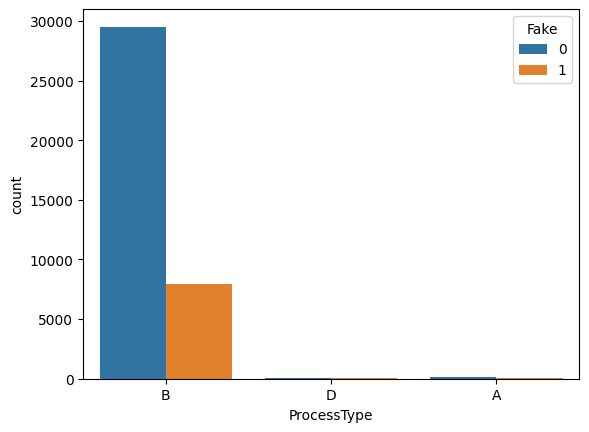

In [ ]:
sns.countplot(data=df_train, x='ProcessType', hue='Fake')

<Axes: xlabel='DeclarationOfficeID', ylabel='count'>

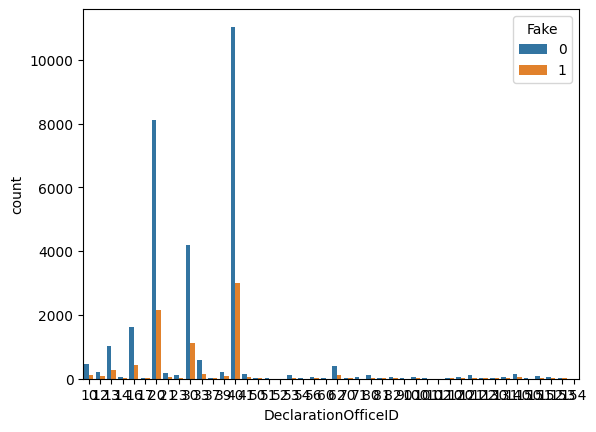

In [ ]:
sns.countplot(data=df_train, x='DeclarationOfficeID', hue='Fake')

<Axes: xlabel='TransactionNature', ylabel='count'>

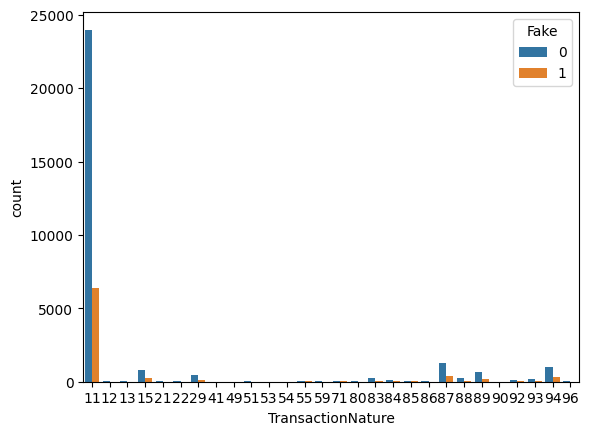

In [ ]:
sns.countplot(data=df_train, x='TransactionNature', hue='Fake')

<Axes: xlabel='Type', ylabel='count'>

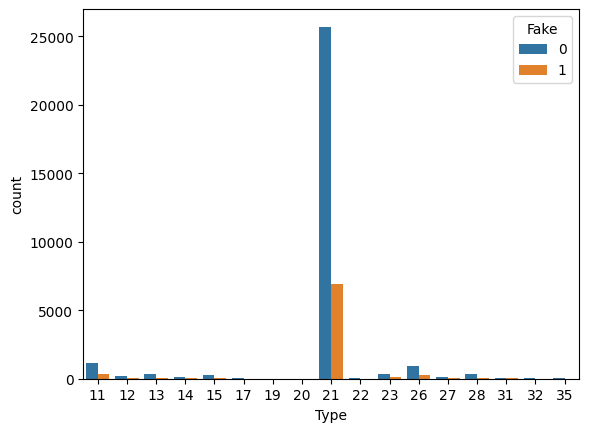

In [ ]:
sns.countplot(data=df_train, x='Type', hue='Fake')

<Axes: xlabel='PaymentType', ylabel='count'>

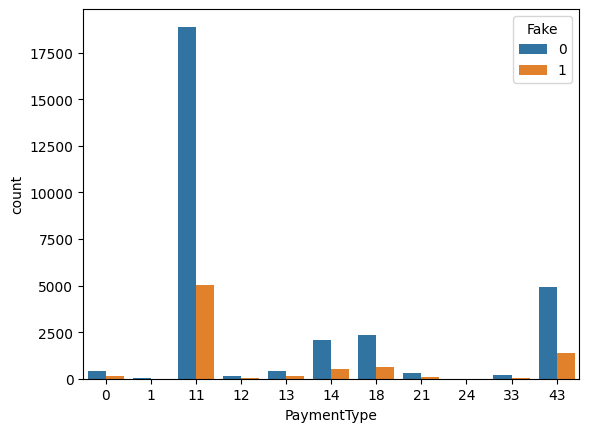

In [ ]:
sns.countplot(data=df_train, x='PaymentType', hue='Fake')

<Axes: xlabel='BorderTransportMeans', ylabel='count'>

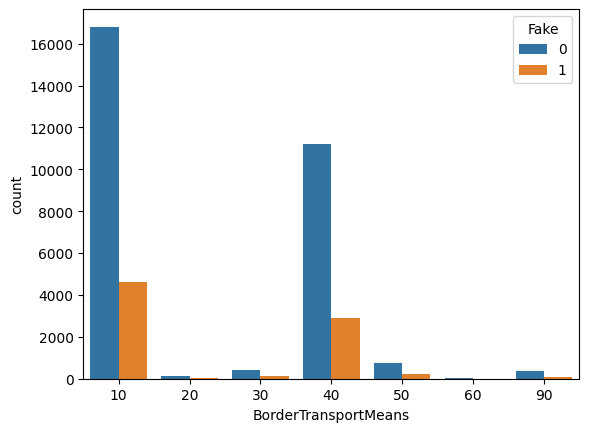

In [ ]:
sns.countplot(data=df_train, x='BorderTransportMeans', hue='Fake')

<Axes: xlabel='DutyRegime', ylabel='count'>

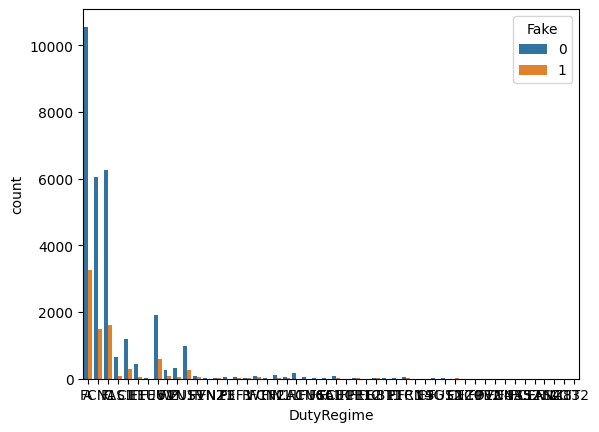

In [ ]:
sns.countplot(data=df_train, x='DutyRegime', hue='Fake')

<Axes: xlabel='DisplayIndicator', ylabel='count'>

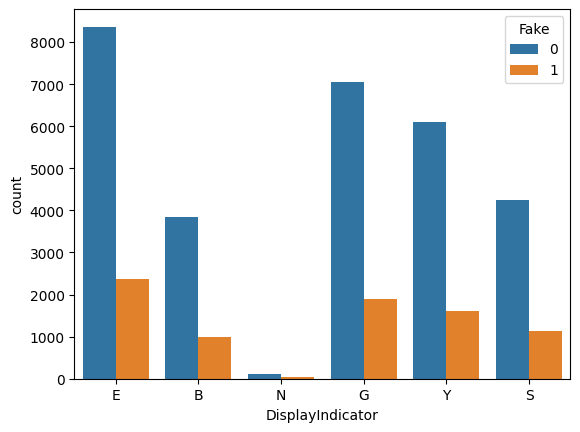

In [ ]:
sns.countplot(data=df_train, x='DisplayIndicator', hue='Fake')

<Axes: xlabel='ClassificationID', ylabel='count'>

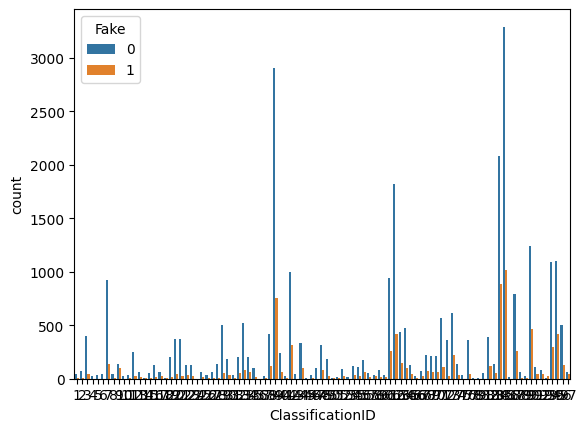

In [ ]:
sns.countplot(data=df_train, x='ClassificationID', hue='Fake')

In [ ]:
df_train = copy_train.copy()
df_test = copy_test.copy()
df_train

,ID,IssueDateTime,DeclarationOfficeID,ProcessType,TransactionNature,Type,PaymentType,BorderTransportMeans,DeclarerID,ImporterID,ClassificationID,ExportationCountry,OriginCountry,TaxRate,DutyRegime,DisplayIndicator,TotalGrossMassMeasure(KG),AdValoremTaxBaseAmount(Won),Fake
0,30777033,1,40,B,11,26,11,10,VYTOBWO,FLS9TIQ,94,US,US,8.0,A,E,945.0,720373.50,0
1,47773104,1,40,B,11,27,11,50,T3TZ0DI,POTOUTQ,48,CN,CN,0.0,FCN1,E,3821.0,85590.40,1
2,80698705,1,40,B,11,21,11,40,8TPRV05,DGF99GW,61,CN,CN,13.0,A,B,160.0,2496.00,0
3,44182350,1,30,D,11,21,11,40,XCIAAPR,AUNYBCR,95,CN,CN,0.0,FCN1,E,10.0,10030.00,0
4,14249938,1,152,B,11,21,11,10,158PVN2,7D71NIV,32,IT,IT,6.5,C,N,7265.0,6686706.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37742,24481775,12,40,B,11,21,11,10,DM8H44I,B99SKQY,63,PH,PH,0.0,FAS1,G,110.6,254.38,0
37743,30520377,12,20,B,11,26,13,40,FYJTYAA,L99S2KU,5,RU,RU,3.0,A,E,500.0,3268100.00,0
37744,90393257,12,30,B,80,11,11,40,N12W66C,PP50GKM,84,IT,IT,0.0,FEU1,S,3186.0,697734.00,1
37745,23757147,12,20,B,11,21,11,10,M64ILNR,3XPWUVG,94,CN,CN,2.4,FCN1,S,750.0,241425.00,0


In [ ]:
for col in df_train.columns:
  print(col)

ID
IssueDateTime
DeclarationOfficeID
ProcessType
TransactionNature
Type
PaymentType
BorderTransportMeans
DeclarerID
ImporterID
ClassificationID
ExportationCountry
OriginCountry
TaxRate
DutyRegime
DisplayIndicator
TotalGrossMassMeasure(KG)
AdValoremTaxBaseAmount(Won)
Fake


In [ ]:
label_enc_cols = ['DutyRegime', 'ExportationCountry', 'OriginCountry']#
t_cols = ['TransactionNature', 'DeclarationOfficeID', 'Type', ]
drop_cols = ['ID', 'IssueDateTime', 'ProcessType', 'BorderTransportMeans', 'PaymentType', 'DeclarerID', 'ImporterID', 'DisplayIndicator']

In [ ]:
# get the unique labels
unique_cat_cols = dict()
for col in label_enc_cols:
  unique_cat_cols[col] = df_train[col].unique()
print(unique_cat_cols)


{'DutyRegime': array(['A', 'FCN1', 'C', 'FAS1', 'CIT', 'E1', 'FEU6', 'FEU1', 'W2',
       'FVN1', 'FUS1', 'F', 'FVN2', 'FNZ1', 'P3', 'FEF1', 'R', 'W1',
       'FCN2', 'FIN1', 'FCA1', 'L', 'FCN6', 'FUS6', 'FCL1', 'FAU1',
       'FCECR1', 'FPE1', 'FEF2', 'FGB1', 'CIT1', 'P1', 'FTR1', 'FCN4',
       'C3', 'FSG1', 'FUS2', 'C1', 'FNZ9', 'FCO1', 'FPE2', 'FVN4', 'FCN3',
       'FUS5', 'FAS2', 'FCENI1', 'FAS4', 'FNZ8', 'CIT3', 'CIT2'],
      dtype=object), 'ExportationCountry': array(['US', 'CN', 'IT', 'TH', 'VN', 'JP', 'DE', 'NL', 'ID', 'SY', 'KR',
       'FR', 'BE', 'GB', 'HK', 'MX', 'TW', 'MY', 'IN', 'TR', 'SG', 'AU',
       'PH', 'DK', 'AT', 'NZ', 'RU', 'BR', 'NO', 'PL', 'BD', 'FI', 'ES',
       'IE', 'CA', 'AE', 'CZ', 'QA', 'EE', 'SR', 'CL', 'SE', 'CO', 'PE',
       'AZ', 'KH', 'RO', 'CH', 'CR', 'DJ', 'LV', 'GR', 'UY', 'GN', 'PT',
       'LT', 'LK', 'MM', 'SD', 'LR', 'ZZ', 'PK', 'LU', 'SA', 'HU', 'AR',
       'SI', 'SL', 'KG', 'TN', 'ZA', 'IL', 'BH', 'PA', 'KE', 'SV', 'SK',
       'GT', '

In [ ]:
for col in label_enc_cols:
  df_train[col] = pd.factorize(df_train[col], sort=True)[0]
# df_train['ClassificationID'] = df_train[C].astype(str)
te = TargetEncoder()
for col in t_cols:
  df_train[col] = df_train.groupby(col)['Fake'].transform('mean')

In [ ]:
dict_cat_to_num = {col: list(df_train[col].unique()) for col in label_enc_cols}
print(dict_cat_to_num)

{'DutyRegime': [0, 18, 1, 10, 4, 8, 27, 26, 49, 41, 37, 9, 42, 30, 46, 24, 47, 48, 19, 29, 14, 44, 22, 40, 17, 13, 15, 33, 25, 28, 5, 45, 36, 21, 3, 35, 38, 2, 32, 23, 34, 43, 20, 39, 11, 16, 12, 31, 7, 6], 'ExportationCountry': [104, 13, 43, 99, 107, 45, 17, 69, 38, 98, 49, 27, 6, 28, 35, 65, 102, 66, 41, 101, 90, 3, 76, 19, 2, 72, 86, 9, 70, 78, 5, 26, 24, 39, 10, 0, 16, 82, 22, 96, 12, 89, 14, 74, 4, 48, 84, 11, 15, 18, 57, 32, 105, 31, 80, 55, 53, 61, 88, 54, 109, 77, 56, 87, 37, 1, 91, 93, 47, 100, 108, 40, 8, 73, 46, 97, 92, 33, 36, 71, 42, 59, 23, 79, 68, 7, 67, 60, 20, 103, 50, 62, 25, 58, 64, 106, 51, 83, 44, 34, 81, 95, 30, 29, 85, 21, 94, 75, 52, 63], 'OriginCountry': [107, 18, 46, 100, 51, 112, 48, 4, 72, 40, 98, 22, 32, 104, 23, 69, 114, 31, 8, 79, 37, 75, 28, 88, 16, 73, 43, 86, 81, 7, 30, 41, 39, 80, 68, 14, 21, 64, 91, 11, 60, 77, 57, 96, 101, 17, 5, 90, 20, 19, 102, 105, 63, 50, 85, 115, 97, 29, 109, 35, 108, 34, 83, 26, 55, 56, 93, 58, 27, 3, 38, 94, 15, 82, 42, 62, 0

In [ ]:
df_train = df_train.drop(columns=drop_cols)

In [ ]:
print(df_train.columns)

Index(['DeclarationOfficeID', 'TransactionNature', 'Type', 'ClassificationID',
       'ExportationCountry', 'OriginCountry', 'TaxRate', 'DutyRegime',
       'TotalGrossMassMeasure(KG)', 'AdValoremTaxBaseAmount(Won)', 'Fake'],
      dtype='object')


In [ ]:
train_data = df_train.copy()

In [ ]:
features = [col for col in df_train.columns if col!= 'Fake']
print(features)

['DeclarationOfficeID', 'TransactionNature', 'Type', 'ClassificationID', 'ExportationCountry', 'OriginCountry', 'TaxRate', 'DutyRegime', 'TotalGrossMassMeasure(KG)', 'AdValoremTaxBaseAmount(Won)']


In [ ]:
train_Y = train_data['Fake']
train_X = train_data[features]
k = 547
knn = KNeighborsClassifier(n_neighbors=k, weights="distance")
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=16)
knn.fit(train_X, train_Y)
scores = cross_val_score(knn, train_X, train_Y, cv=kfold)
print("Train Accuracy: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

Train Accuracy: 0.9218 (+/- 0.0031)


In [ ]:
print(features)

['DeclarationOfficeID', 'TransactionNature', 'Type', 'ClassificationID', 'ExportationCountry', 'OriginCountry', 'TaxRate', 'DutyRegime', 'TotalGrossMassMeasure(KG)', 'AdValoremTaxBaseAmount(Won)']


In [ ]:
df_test

,ID,IssueDateTime,DeclarationOfficeID,ProcessType,TransactionNature,Type,PaymentType,BorderTransportMeans,DeclarerID,ImporterID,ClassificationID,ExportationCountry,OriginCountry,TaxRate,DutyRegime,DisplayIndicator,TotalGrossMassMeasure(KG),AdValoremTaxBaseAmount(Won)
0,91339477,1,20,B,11,21,11,40,ZN0A109,XW2KKGW,48,IT,CN,0.0,C,E,1.0,1.10
1,12379295,1,40,B,94,21,18,40,H4TRKS6,7WMKPUM,93,CH,AT,8.0,A,G,9.9,373860.63
2,51522974,1,20,D,86,21,11,40,C2N4N27,CL38DL7,84,US,US,0.0,C,S,23.2,5143.44
3,88807751,1,20,B,11,21,11,50,PF1L1IG,V5HG9HW,84,HK,CN,0.0,CIT,Y,17.0,1130.50
4,20036753,1,40,B,11,11,11,10,WMXXNMR,803AH17,62,CN,CN,13.0,A,S,10.0,658.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16224,98616543,6,40,B,11,21,43,10,R5P6P4N,G0E60MS,39,JP,JP,6.5,C,B,1.3,41.08
16225,98226195,6,40,B,11,21,11,40,OZB7KED,M5KYBBQ,52,JP,JP,8.0,A,E,0.6,262.74
16226,94723917,6,20,B,11,21,18,10,OZB7KED,IG7X8S4,59,CN,CN,0.0,FCN1,Y,1000.0,592700.00
16227,12518109,6,20,B,94,21,43,10,JYVH8IJ,9K8B1YZ,62,CN,CN,13.0,A,G,42.0,2175.60


In [ ]:

from sklearn.preprocessing import LabelEncoder
for col in label_enc_cols:
    df_test[col] = df_test[col].map(lambda x:dict_cat_to_num[col][list(unique_cat_cols[col]).index(x)] if x in unique_cat_cols[col] else -1)

for col in t_cols:
  df_test[col] = df_train.groupby(col)['Fake'].transform('mean')

In [ ]:
df_test = df_test.drop(columns=drop_cols)

In [ ]:
df_test.columns

Index(['DeclarationOfficeID', 'TransactionNature', 'Type', 'ClassificationID',
       'ExportationCountry', 'OriginCountry', 'TaxRate', 'DutyRegime',
       'TotalGrossMassMeasure(KG)', 'AdValoremTaxBaseAmount(Won)'],
      dtype='object')

In [ ]:
df_test

,DeclarationOfficeID,TransactionNature,Type,ClassificationID,ExportationCountry,OriginCountry,TaxRate,DutyRegime,TotalGrossMassMeasure(KG),AdValoremTaxBaseAmount(Won)
0,0.213150,0.210805,0.202401,48,43,18,0.0,1,1.0,1.10
1,0.213150,0.210805,0.244792,93,11,4,8.0,0,9.9,373860.63
2,0.213150,0.210805,0.212574,84,104,107,0.0,1,23.2,5143.44
3,0.211109,0.210805,0.212574,84,35,18,0.0,4,17.0,1130.50
4,0.171875,0.210805,0.212574,62,13,18,13.0,0,10.0,658.00
...,...,...,...,...,...,...,...,...,...,...
16224,0.208637,0.210805,0.212574,39,45,48,6.5,1,1.3,41.08
16225,0.213150,0.210805,0.212574,52,45,48,8.0,0,0.6,262.74
16226,0.210511,0.222888,0.212574,59,13,18,0.0,18,1000.0,592700.00
16227,0.213150,0.210805,0.212574,62,13,18,13.0,0,42.0,2175.60


In [ ]:
# features = df_test.columns[:]
prediction = knn.predict(df_test[features])

In [ ]:
c = 0
for res in prediction:
  print(res)
  if res == 1:
    c += 1

print((c/16229)*100)

Streaming output truncated to the last 5000 lines.
0
0
0
0
0
0
0
0
1
0
1
1
0
0
0
0
1
0
0
0
1
0
0
0
1
1
0
0
1
0
1
0
1
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
1
0
0
0
1
0
0
0
1
0
0
1
0
0
1
0
0
0
1
1
1
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
1
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0

In [ ]:
test_result = pd.DataFrame({'ID': test_frame['ID'], 'Fake': prediction})
test_result.to_csv('Knn543_TransNature_decID_Type.csv', index=False)